In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import findspark
findspark.init("C:\spark\spark-3.5.0-bin-hadoop3")

In [40]:
import numpy as np 
import pandas as pd
from datasets import load_dataset
from itertools import islice

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [4]:
from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

from pyspark.ml.recommendation import ALS

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql.functions import col
from itertools import product

from cosine_similarity import ItemSimilarity
from cosine_similarity import UserSimilarity

In [5]:
try:
    sc = SparkContext.getOrCreate()

    if sc:
        sc.stop()
except Exception as e:
    print(e)

spark = SparkSession.builder\
    .master('local')\
        .appName('ALS_Recommendation')\
            .getOrCreate()

sc = spark.sparkContext 

In [6]:
print(f'App Name : {sc.appName}')
print(f'Version : {sc.version}')
print(f"Spark User : {sc.sparkUser()}")

App Name : ALS_Recommendation
Version : 3.5.0
Spark User : 90530


In [7]:
sc

<SparkContext master=local appName=ALS_Recommendation>

In [8]:
dataset = load_dataset("ashraq/movielens_ratings")  

df = dataset['train'].to_pandas()

Found cached dataset parquet (C:/Users/90530/.cache/huggingface/datasets/ashraq___parquet/ashraq--movielens_ratings-139b1d983e5c8861/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
df.head(5)

,imdbId,tmdbId,movie_id,user_id,rating,title,genres,posters
0,tt2096673,150540,2307,11923,3.5,Inside Out (2015),Adventure|Animation|Children|Comedy|Drama|Fantasy,https://m.media-amazon.com/images/M/MV5BOTgxMD...
1,tt5160928,393732,7157,32503,3.0,Mean Dreams (2017),Thriller,https://m.media-amazon.com/images/M/MV5BMDM2OD...
2,tt3498820,271110,1398,20241,3.0,Captain America: Civil War (2016),Action|Sci-Fi|Thriller,https://m.media-amazon.com/images/M/MV5BMjQ0MT...
3,tt3040964,278927,2625,42975,5.0,The Jungle Book (2016),Adventure|Drama|Fantasy,https://m.media-amazon.com/images/M/MV5BMTc3NT...
4,tt5308322,440021,8457,31336,3.0,Happy Death Day (2017),Horror|Mystery|Thriller,https://m.media-amazon.com/images/M/MV5BYzZhY2...


In [10]:
df_train = dataset['train'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres', 'title']]
df_val = dataset['validation'].to_pandas()[['movie_id', 'user_id', 'rating', 'genres', 'title']]

In [11]:
df_train.head(5)

,movie_id,user_id,rating,genres,title
0,2307,11923,3.5,Adventure|Animation|Children|Comedy|Drama|Fantasy,Inside Out (2015)
1,7157,32503,3.0,Thriller,Mean Dreams (2017)
2,1398,20241,3.0,Action|Sci-Fi|Thriller,Captain America: Civil War (2016)
3,2625,42975,5.0,Adventure|Drama|Fantasy,The Jungle Book (2016)
4,8457,31336,3.0,Horror|Mystery|Thriller,Happy Death Day (2017)


In [12]:
df_train.to_csv("../Datas/df_train.csv", index=False)
df_val.to_csv('../Datas/df_val.csv', index=False)

In [13]:
df_rating_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')
df_rating_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select('movie_id', 'user_id', 'rating')

genres_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True).select('genres') 
genres_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select('genres')

title_train = spark.read.csv("../Datas/df_train.csv", header=True, inferSchema=True).select(['movie_id', 'title']) 
title_val = spark.read.csv("../Datas/df_val.csv", header=True, inferSchema=True).select(['movie_id', 'title'])

# concat_data = df_rating_train.union(df_rating_val).limit(10000)

movie_title = title_train.union(title_val)
concat_genres = genres_train.union(genres_val)
concat_data = df_rating_train.union(df_rating_val)

In [14]:
concat_data.describe().show()

+-------+------------------+------------------+------------------+
|summary|          movie_id|           user_id|            rating|
+-------+------------------+------------------+------------------+
|  count|            990425|            990425|            990425|
|   mean| 4057.249363657016|21788.655097559127|3.5557376883661056|
| stddev|3782.8968929842586|12658.790818878151|1.0521822688147535|
|    min|                 1|                 1|               0.5|
|    max|             15604|             44088|               5.0|
+-------+------------------+------------------+------------------+



In [15]:
num_rows = concat_data.count()
num_uniq_movies = len(concat_data.select("movie_id").distinct().collect())

print(f"Number of rows : {num_rows}")
print(f"Number of movie : {num_uniq_movies}")

Number of rows : 990425
Number of movie : 15603


In [16]:
concat_data.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: double (nullable = true)



In [17]:
concat_data.show(10)

+--------+-------+------+
|movie_id|user_id|rating|
+--------+-------+------+
|    2307|  11923|   3.5|
|    7157|  32503|   3.0|
|    1398|  20241|   3.0|
|    2625|  42975|   5.0|
|    8457|  31336|   3.0|
|    2230|  38922|   4.0|
|    5110|  41802|   3.5|
|     935|  36706|   3.5|
|     936|  21320|   5.0|
|    8960|   2930|   2.5|
+--------+-------+------+
only showing top 10 rows



In [18]:
[genres.genres for genres in concat_genres.take(10)]

['Adventure|Animation|Children|Comedy|Drama|Fantasy',
 'Thriller',
 'Action|Sci-Fi|Thriller',
 'Adventure|Drama|Fantasy',
 'Horror|Mystery|Thriller',
 'Adventure|Drama|Sci-Fi',
 'Drama',
 'Crime|Drama|Thriller',
 'Action|Animation|Comedy',
 'Action|Adventure|Children']

In [19]:
for column in concat_data.columns:
    null_row = concat_data.where(col(column).isNull()).count()
    if null_row == 0:
        print(f"{column} has no null value")
    else:
        print(f'{column} has {null_row} null values')

movie_id has no null value
user_id has no null value
rating has no null value


In [20]:
genres_list = []

for genres in concat_genres.collect():
    genres_list.append(genres[0])

genres_text = ""

for g in genres_list:
    genres_text += g + "|"

In [21]:
rdd = sc.parallelize([genres_text])

In [22]:
all_genres = rdd.flatMap(lambda genres: genres.split('|')) \
    .map(lambda genres : (genres, 1)) \
    .reduceByKey(lambda x, y, : x + y)

sortedGenresCounts = sorted(all_genres.collect(), key=lambda x : x[1], reverse=True)
sortedGenresCounts = spark.sparkContext.parallelize(sortedGenresCounts)

In [23]:
for genres, count in islice(sortedGenresCounts.collect(), 15):
    print(f"{genres}: {count}")

Drama: 405151
Action: 294340
Comedy: 275970
Adventure: 233625
Thriller: 223726
Sci-Fi: 208094
Fantasy: 113806
Crime: 111199
Animation: 106115
Romance: 87352
Horror: 80338
Children: 63295
Mystery: 48418
Documentary: 41649
War: 39009


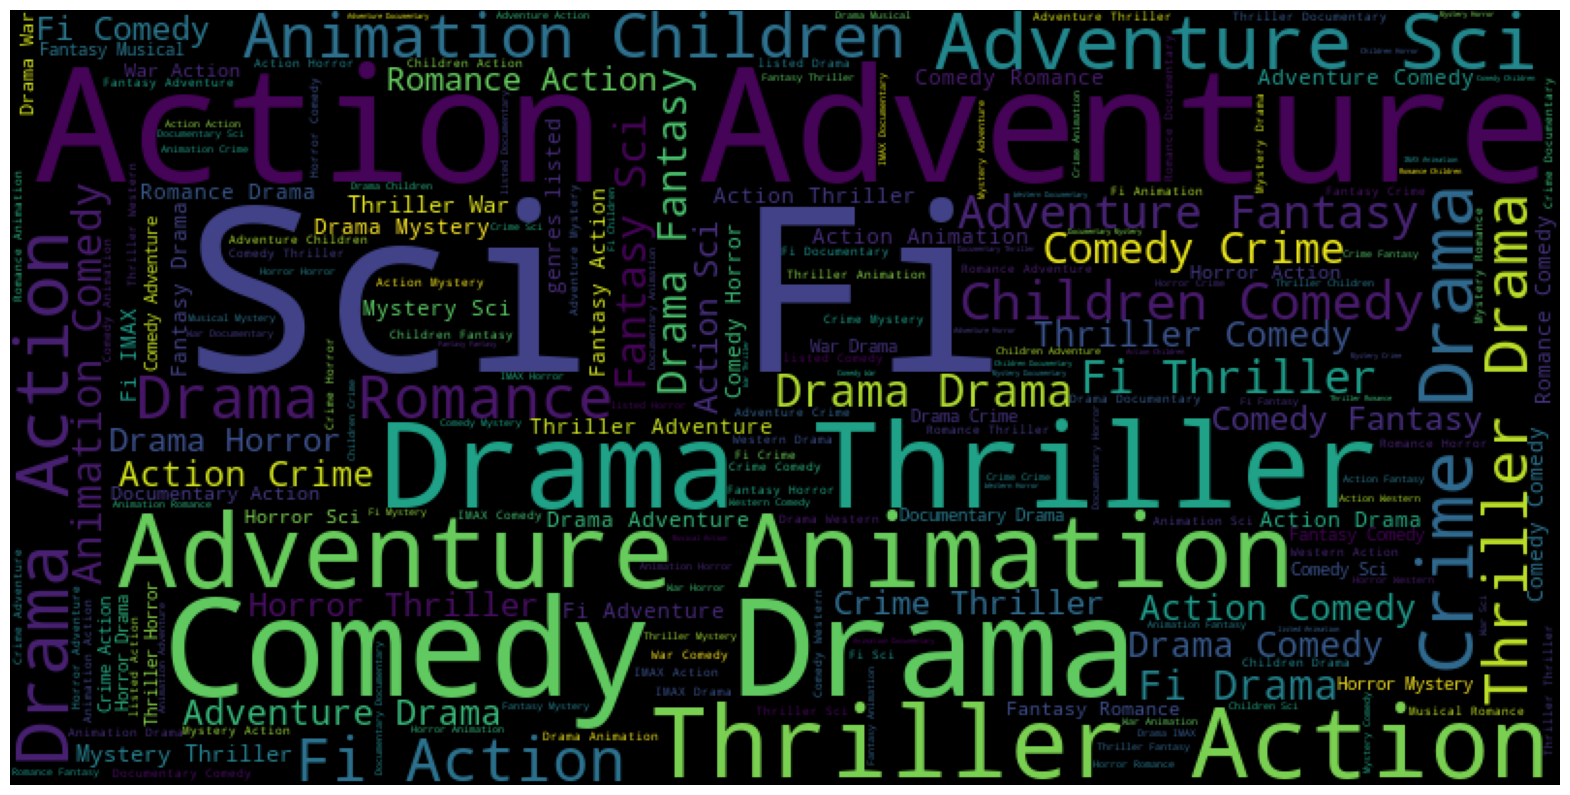

In [53]:
plt.subplots(figsize=(20, 15))
genres_cloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(genres_list))
plt.imshow(genres_cloud)
plt.axis('off')
plt.show()

<Axes: >

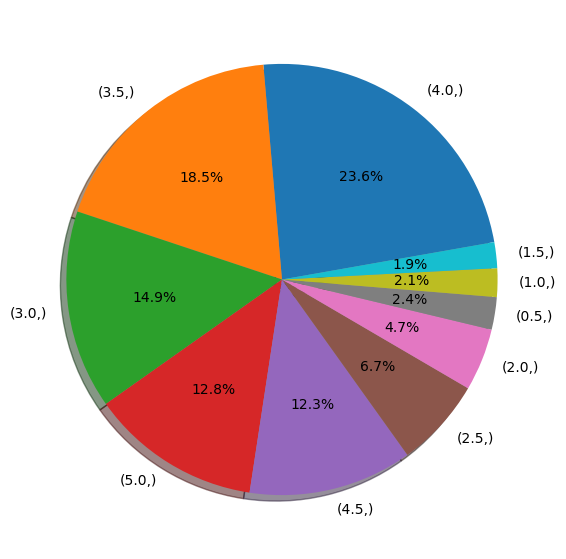

In [24]:
plt.figure(figsize=(7, 7))
rating_list = [rating[0] for rating in concat_data.select("rating").collect()]
pd.DataFrame(rating_list).value_counts().plot(
    kind='pie',
    shadow=True,
    startangle=10,
    autopct='%1.1f%%',
    )

Text(0, 0.5, 'Frequency')

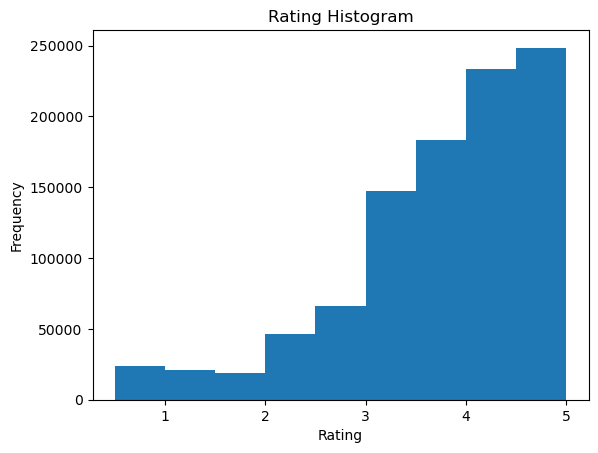

In [25]:
bin_edges = np.arange(0.5, 5.5, step=0.5)

plt.hist(
    rating_list, bins=bin_edges, histtype='bar'
)

plt.title("Rating Histogram")
plt.xlabel('Rating')    
plt.ylabel('Frequency')

In [18]:
indexer_movie = StringIndexer(inputCol='movie_id', outputCol='movie_index')
indexer_user = StringIndexer(inputCol='user_id', outputCol='user_index')

In [19]:
pipeline = Pipeline(stages=[indexer_movie, indexer_user])

tf_df = pipeline.fit(concat_data).transform(concat_data)

tf_df.show(10)

+--------+-------+------+-----------+----------+
|movie_id|user_id|rating|movie_index|user_index|
+--------+-------+------+-----------+----------+
|    2307|  11923|   3.5|        3.0|    3546.0|
|    7157|  32503|   3.0|     3137.0|     587.0|
|    1398|  20241|   3.0|       20.0|    9092.0|
|    2625|  42975|   5.0|       78.0|    6216.0|
|    8457|  31336|   3.0|      303.0|     716.0|
|    2230|  38922|   4.0|        0.0|    2575.0|
|    5110|  41802|   3.5|       96.0|     362.0|
|     935|  36706|   3.5|       13.0|    1282.0|
|     936|  21320|   5.0|        8.0|   30282.0|
|    8960|   2930|   2.5|      105.0|     562.0|
+--------+-------+------+-----------+----------+
only showing top 10 rows



In [20]:
(train_data, test_data) = tf_df.randomSplit([0.9, 0.1], seed=5030)

print(f"train count : {train_data.count()}")
print(f"test count : {test_data.count()}")

train count : 891276
test count : 99149


In [29]:
models = []
df = pd.DataFrame(columns=['rank_', 'iteration', 'regParam_', 'model', 'predictions', 'rmse', 'mse'])

def als_model(rank_, iteration, regParam_):
        als = ALS(
                rank = rank_,
                maxIter = iteration,
                regParam = regParam_, 
                numUserBlocks = 10, # Default
                numItemBlocks = 10, # Default
                implicitPrefs = False, # Default
                alpha = 1.0, # Default
                userCol = 'user_id', # Default
                itemCol = 'movie_id', # Default
                seed = None, # Default
                ratingCol = 'rating', # Default
                nonnegative = False, # Default
                checkpointInterval = 10, # Default
                intermediateStorageLevel = 'MEMORY_AND_DISK', # Default
                finalStorageLevel = 'MEMORY_AND_DISK', # Default
                coldStartStrategy = 'nan', # Default
                blockSize = 4096, # Default
        )

        model = als.fit(train_data)
        model.setPredictionCol("predictions")
        predictions = model.transform(test_data)
        predictions = predictions.filter(predictions.predictions != float('nan'))

        evaluator=RegressionEvaluator(metricName="rmse",labelCol="rating",predictionCol="predictions")
        rmse=evaluator.evaluate(predictions)

        evaluator2=RegressionEvaluator(metricName="mse",labelCol="rating",predictionCol="predictions")
        mse=evaluator2.evaluate(predictions)

        models.append(model)
        df.loc[len(df)] = [rank_, iteration, regParam_, model, predictions, rmse, mse] 

In [30]:
rank_params = [10, 50, 100]
iteration_params = [10, 15, 20]
lambda_params = [0.1, 0.01]

for r, i, l in product(rank_params, iteration_params, lambda_params):
    als_model(r, i, l)
    print(f"model {len(df)} is done ")

model 1 is done 
model 2 is done 
model 3 is done 
model 4 is done 
model 5 is done 
model 6 is done 
model 7 is done 
model 8 is done 
model 9 is done 
model 10 is done 
model 11 is done 
model 12 is done 
model 13 is done 
model 14 is done 
model 15 is done 
model 16 is done 
model 17 is done 
model 18 is done 


In [31]:
df.groupby('mse').min().head()

,rank_,iteration,regParam_,model,predictions,rmse
mse,,,,,,
0.688977,50,20,0.1,"ALSModel: uid=ALS_8faa114910c9, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.830046
0.689436,100,20,0.1,"ALSModel: uid=ALS_0bd1c122e4cd, rank=100","DataFrame[movie_id: int, user_id: int, rating:...",0.830323
0.690706,10,20,0.1,"ALSModel: uid=ALS_3c4bb5ca5cc5, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.831087
0.695370,10,15,0.1,"ALSModel: uid=ALS_3e16878f3023, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.833889
0.696436,50,15,0.1,"ALSModel: uid=ALS_9ca26eee3a4f, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.834527


In [32]:
df.groupby('rmse').min().head()

,rank_,iteration,regParam_,model,predictions,mse
rmse,,,,,,
0.830046,50,20,0.1,"ALSModel: uid=ALS_8faa114910c9, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.688977
0.830323,100,20,0.1,"ALSModel: uid=ALS_0bd1c122e4cd, rank=100","DataFrame[movie_id: int, user_id: int, rating:...",0.689436
0.831087,10,20,0.1,"ALSModel: uid=ALS_3c4bb5ca5cc5, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.690706
0.833889,10,15,0.1,"ALSModel: uid=ALS_3e16878f3023, rank=10","DataFrame[movie_id: int, user_id: int, rating:...",0.695370
0.834527,50,15,0.1,"ALSModel: uid=ALS_9ca26eee3a4f, rank=50","DataFrame[movie_id: int, user_id: int, rating:...",0.696436


In [33]:
model_mse = [m for m in models if m == df.groupby('mse').min().iloc[0]['model']][0] 

model_rmse = [m for m in models if m == df.groupby('rmse').min().iloc[0]['model']][0]

if model_rmse == model_mse:
    model = model_rmse
    print("models are same")
else:
    print("models arenot same")

models are same


In [34]:
df[df['model'] == model].drop(columns=['model'])

,rank_,iteration,regParam_,predictions,rmse,mse
10,50,20,0.1,"DataFrame[movie_id: int, user_id: int, rating:...",0.830046,0.688977


In [37]:
predictions = df[df['model'] == model]['predictions'].values[0]
predictions.take(10)

[Row(movie_id=32, user_id=5518, rating=4.5, movie_index=139.0, user_index=2671.0, predictions=3.6970267295837402),
 Row(movie_id=41, user_id=41409, rating=3.0, movie_index=333.0, user_index=7777.0, predictions=3.1937365531921387),
 Row(movie_id=41, user_id=42834, rating=2.5, movie_index=333.0, user_index=111.0, predictions=2.562786340713501),
 Row(movie_id=42, user_id=38723, rating=5.0, movie_index=54.0, user_index=3524.0, predictions=4.469514846801758),
 Row(movie_id=86, user_id=1580, rating=3.5, movie_index=67.0, user_index=10474.0, predictions=3.9917402267456055),
 Row(movie_id=86, user_id=29719, rating=5.0, movie_index=67.0, user_index=2904.0, predictions=3.6649973392486572),
 Row(movie_id=86, user_id=32396, rating=4.0, movie_index=67.0, user_index=1724.0, predictions=3.878227949142456),
 Row(movie_id=123, user_id=38311, rating=4.0, movie_index=250.0, user_index=2710.0, predictions=3.7202627658843994),
 Row(movie_id=135, user_id=28170, rating=3.0, movie_index=608.0, user_index=4572

In [124]:
ppredictions = predictions.select(['rating', 'predictions'])

prediction_df = predictions.toPandas()

sorted_df = prediction_df.sort_values(by='rating')
sorted_df = sorted_df.sort_values(by='predictions')

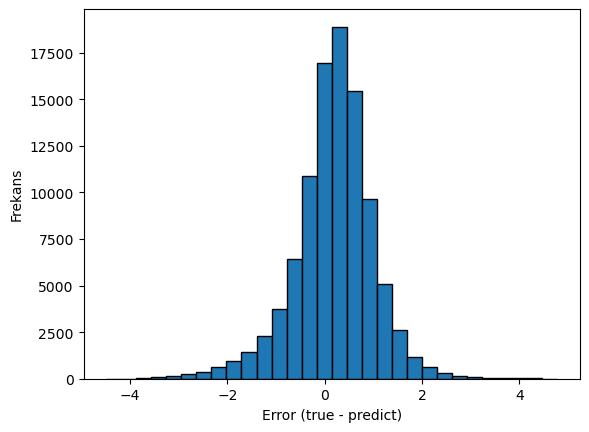

In [145]:
errors = [real - predicted for real, predicted in zip(sorted_df['rating'].values, sorted_df['predictions'].values)]

plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Error (true - predict)')
plt.ylabel('Frekans')
plt.show()

In [87]:
item_object = ItemSimilarity(movie_title=movie_title)

similar_items_df = item_object.item_similarity(model=model, item_id=100, item_number=10)

similar_items_df['movie_title'] = similar_items_df['movie_id'].apply(item_object.id_to_movie)
similar_items_df[['movie_title', 'movie_id', 'cosine_similarity']]

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.1115754, -0.3...|
| 20|[0.08406281, -0.1...|
| 30|[-0.06146804, -0....|
| 40|[-0.109934196, -0...|
| 50|[-0.040442705, 0....|
+---+--------------------+
only showing top 5 rows



,movie_title,movie_id,cosine_similarity
0,11 Flowers (Wo 11) (2011),100,1.000000
1,Kút (2016),8842,0.932072
2,Very Big Shot (2015),6804,0.916926
3,Gabo: The Creation of Gabriel Gracia Marquez (...,5518,0.916215
4,Wonderful Losers: A Different World (2017),10690,0.916014
5,The Man Who Saw Too Much (2015),10398,0.915375
6,Distant Sky - Nick Cave & The Bad Seeds Live i...,10740,0.914036
7,Felices 140 (2015),3717,0.913544
8,We Cause Scenes (2014),1665,0.913215
9,The Role (2013),12858,0.913037


In [42]:
similar_users_df = UserSimilarity.user_similarity(model, user_id=100, user_number=10)
similar_users_df.drop(columns=['vectors'])

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[-0.19535793, -0....|
| 20|[0.19925913, -0.0...|
| 30|[-0.19535793, -0....|
| 40|[-0.040772002, -0...|
| 50|[0.01873152, -0.2...|
+---+--------------------+
only showing top 5 rows



,user_id,cosine_similarity
0,100,1.000000
1,6267,0.991330
2,37210,0.991330
3,6113,0.991330
4,26530,0.991330
5,4150,0.989788
6,9902,0.978346
7,15150,0.975297
8,23131,0.970824
9,36524,0.965967


In [43]:
user_recs = model.recommendForAllUsers(numItems=10)
movie_recommendation = user_recs.where(user_recs.user_id == 100).select("recommendations.movie_id", "recommendations.rating").collect()

movie_df = pd.DataFrame(columns=["userId", 'movieId', 'movieRating'])

movie_id = movie_recommendation[0][0]
movie_rating = movie_recommendation[0][1]

for id_, rating in zip(movie_id, movie_rating):
    movie_df.loc[len(movie_df)] = [100, id_, rating]

movie_df['movie_title'] = movie_df['movieId'].apply(item_object.id_to_movie)

movie_df = movie_df.drop(columns=['movieId'])

movie_df

,userId,movieRating,movie_title
0,100.0,4.736914,NOFX Backstage Passport 2
1,100.0,4.632453,ReMoved (2013)
2,100.0,4.521463,Fifi Howls from Happiness (2013)
3,100.0,4.506836,The Good Mother (2013)
4,100.0,4.461688,Obey Giant (2017)
5,100.0,4.424143,Once Upon a Time in Hollywood (2019)
6,100.0,4.392559,Truth and Justice (2019)
7,100.0,4.201278,Once Upon a Ladder (2016)
8,100.0,4.175925,La vie nous appartient (2016)
9,100.0,4.162373,Punk the Capital: Building a Sound Movement


In [44]:
item_recs = model.recommendForAllItems(numUsers=10)
user_recommendation = item_recs.where(item_recs.movie_id == 100).select("recommendations.user_id", "recommendations.rating").collect()

user_df = pd.DataFrame(columns=['movie_title', 'userId', 'movieRating'])

user_id = user_recommendation[0][0]
movie_rating = user_recommendation[0][1]

for id_, rating in zip(user_id, movie_rating):
    user_df.loc[len(user_df)] = [item_object.id_to_movie(100), id_, rating]

user_df

,movie_title,userId,movieRating
0,11 Flowers (Wo 11) (2011),25449,5.060557
1,11 Flowers (Wo 11) (2011),24284,5.029696
2,11 Flowers (Wo 11) (2011),28973,5.025539
3,11 Flowers (Wo 11) (2011),42643,5.005495
4,11 Flowers (Wo 11) (2011),37642,4.993147
5,11 Flowers (Wo 11) (2011),39044,4.972250
6,11 Flowers (Wo 11) (2011),8356,4.914187
7,11 Flowers (Wo 11) (2011),33794,4.883769
8,11 Flowers (Wo 11) (2011),29861,4.880843
9,11 Flowers (Wo 11) (2011),34101,4.863043


In [ ]:
spark.stop()